In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from traj_utils import *
import matplotlib.pyplot as plt
from viz_utils import *

In [2]:
%%time
aux, targets, run_paths = [], [], []
n_couldnt_load_runs = 0

#for d in range(N_RUNNERS):
for d in range(1): # Just for a single runner
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"{BLENDER_MEMBANK_ROOT}/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets/*.npy"))
        targets_paths = [f'{run_path}/targets/{i}.npy' for i in range(1,EPISODE_LEN+1)]
        
        if n_targets_paths_files < len(targets_paths):
            print(run_path)
            n_couldnt_load_runs += 1
            continue
            
        _aux = np.concatenate([np.load(f'{run_path}/aux/{i}.npy') for i in range(1,EPISODE_LEN+1)], axis=0)
        _targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        aux.append(_aux)
        targets.append(_targets)
        run_paths.append(run_path)
        
aux = na(np.stack(aux, axis=0), AUX_PROPS)
targets = np.stack(targets, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

/media/ssd2/blender_membank_frameskip/dataloader_00/run_310
/media/ssd2/blender_membank_frameskip/dataloader_00/run_311
/media/ssd2/blender_membank_frameskip/dataloader_00/run_312
/media/ssd2/blender_membank_frameskip/dataloader_00/run_313
/media/ssd2/blender_membank_frameskip/dataloader_00/run_314
/media/ssd2/blender_membank_frameskip/dataloader_00/run_315
/media/ssd2/blender_membank_frameskip/dataloader_00/run_316
/media/ssd2/blender_membank_frameskip/dataloader_00/run_317
/media/ssd2/blender_membank_frameskip/dataloader_00/run_318
/media/ssd2/blender_membank_frameskip/dataloader_00/run_319
/media/ssd2/blender_membank_frameskip/dataloader_00/run_320
/media/ssd2/blender_membank_frameskip/dataloader_00/run_321
/media/ssd2/blender_membank_frameskip/dataloader_00/run_322
/media/ssd2/blender_membank_frameskip/dataloader_00/run_323
/media/ssd2/blender_membank_frameskip/dataloader_00/run_324
/media/ssd2/blender_membank_frameskip/dataloader_00/run_325
/media/ssd2/blender_membank_frameskip/da

In [3]:
all_wp_angles, all_wp_dists, all_wp_rolls, all_wp_zs = np.split(targets, 4, axis=-1)

In [4]:
%%time
speed_mask = get_speed_mask(aux[:,:,'speed'], aux[:,:,'has_map'])
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)
all_curvatures = get_curvatures_from_headings_batch(all_headings)

CPU times: user 1.28 s, sys: 0 ns, total: 1.28 s
Wall time: 1.28 s


In [5]:
aux.shape

(310, 170, 40)

In [6]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape, speed_mask.shape

((310, 170, 30),
 (310, 170, 30),
 (310, 170, 30),
 (310, 170, 30),
 (310, 170, 30))

In [7]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .2:
        print(i, m)
        mm += 1

10 0.31103832
265 0.31251955


In [8]:
ix = 0
run_paths[ix]

'/media/ssd2/blender_membank_frameskip/dataloader_00/run_0'

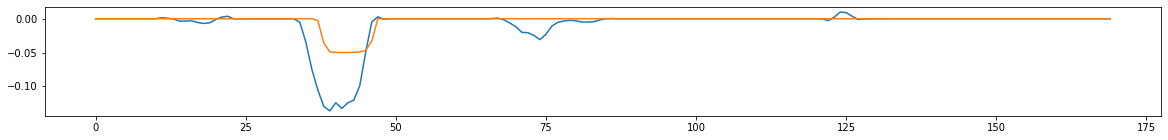

In [9]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[ix,:,0])
plt.plot(aux[ix,:,'curvature_at_ego'])

In [10]:
aux[ix,:,'curvature_at_ego'].max(), aux[ix,:,'curvature_at_ego'].min()

(NamedArray(2.7166567e-05, dtype=float32),
 NamedArray(-0.04998049, dtype=float32))

In [11]:
import plotly.graph_objects as go
import plotly.express as px

In [12]:

y = aux[ix, :, "tire_angle"]

fig = px.scatter(x=list(range(len(y))), y=y, width=1000, height=400)

fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 0])
fig.add_scatter(x=list(range(len(y))), y=moving_average_n(all_wp_angles[ix], 5)[:, 0])

In [13]:
# view single run

#y = all_wp_angles[ix, :, 0] 
y = aux[ix, :, "tire_angle"]

fig = px.scatter(x=list(range(len(y))), y=y, width=1000, height=400)

fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 0])
fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 2])
fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 4])
fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 6])
fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 8])

#fig.update_xaxes(range=[0, 50])
#fig.update_yaxes(range=[0, 12])
fig.show()

In [14]:
# avg te
te = abs((aux[:, 1:, "tire_angle"] - aux[:, :-1, "tire_angle"]))
te.mean()

NamedArray(0.00610967, dtype=float32)

In [15]:
# avg te on tight curves
te[aux[:, 1:, "tire_angle"]>.2].mean()

NamedArray(0.06145587, dtype=float32)

50733.0

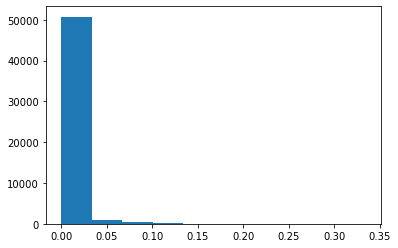

In [16]:
plt.hist(te.flatten())[0][0]

In [17]:
fig = px.scatter(x=abs(aux[::100,1:,"tire_angle"].flatten()), y=te[::100].flatten(), width=600, height=600)
fig.show()

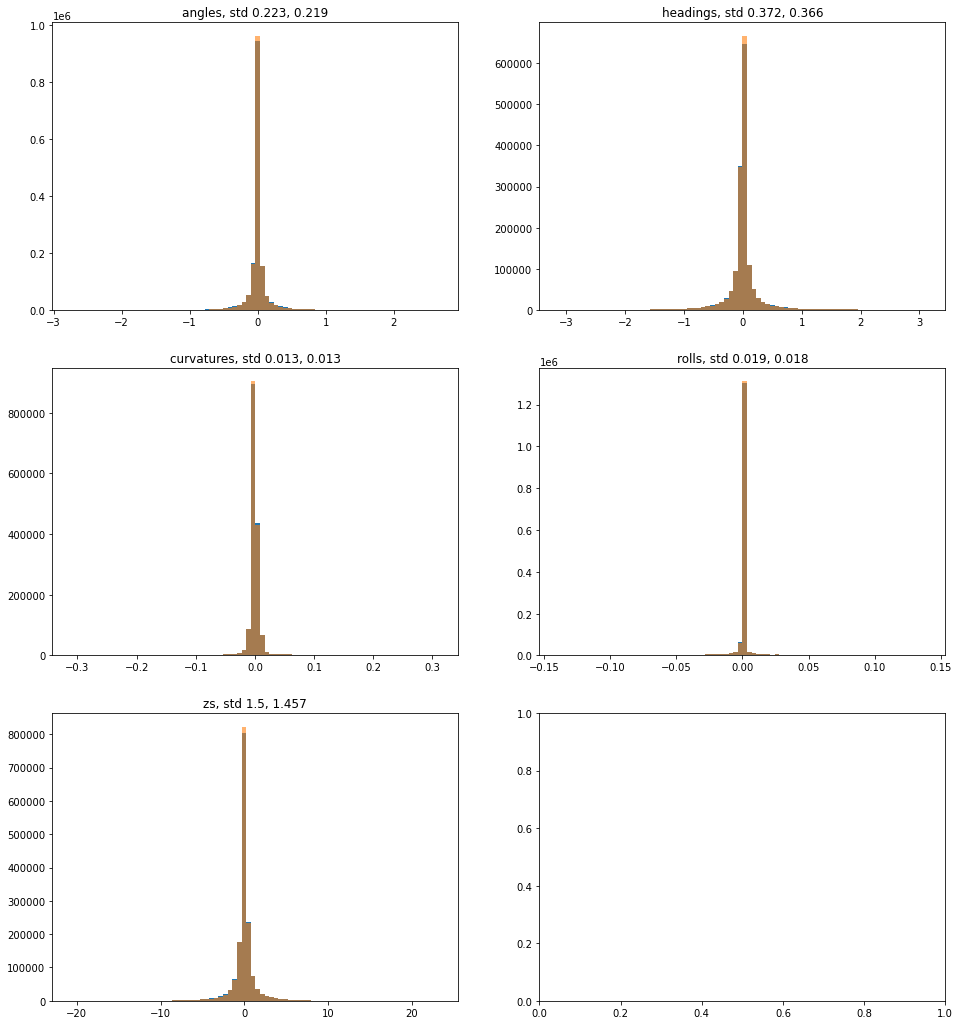

In [18]:
ws = [all_wp_angles, all_headings, all_curvatures, all_wp_rolls, all_wp_zs]
plot_wps(ws, speed_mask)

In [19]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02406066, 0.02992709, 0.03568023, 0.0414576 , 0.04724585,
       0.05303169, 0.05880861, 0.06457296, 0.07032114, 0.07604638,
       0.08174148, 0.08739982, 0.09302197, 0.09860991, 0.10415569,
       0.10965775, 0.11511328, 0.12051893, 0.12587701, 0.13105357,
       0.18034387, 0.22595575, 0.2676512 , 0.306081  , 0.3411352 ,
       0.37333578, 0.40245298, 0.42832053, 0.4521443 , 0.46475363],
      dtype=float32)

In [20]:
mean_headings[-1] / mean_headings[0]

19.315912

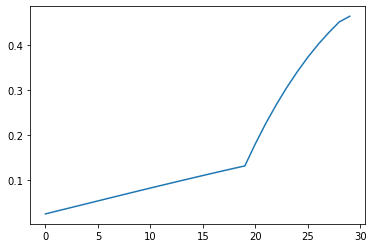

In [21]:
plt.plot(mean_headings)

In [22]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01371131, 0.01626822, 0.01897487, 0.02174323, 0.02454494,
       0.02736673, 0.03019989, 0.03304088, 0.03588486, 0.03872929,
       0.04157155, 0.04441079, 0.04724535, 0.05007361, 0.05289425,
       0.05570539, 0.05850478, 0.06129394, 0.06407128, 0.06683701,
       0.09377812, 0.11921282, 0.14307474, 0.16545098, 0.18649985,
       0.20631059, 0.22493811, 0.24243298, 0.25882027, 0.2741895 ],
      dtype=float32)

In [23]:
mean_angles[-1] / mean_angles[0]

19.997322

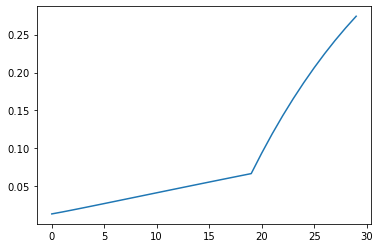

In [24]:
plt.plot(mean_angles)

In [25]:
all_wp_angles[:,:,0].std()

0.03862426

In [26]:
AUX_TARGET_PROPS

['has_stop',
 'stop_dist',
 'has_lead',
 'lead_dist',
 'lead_speed',
 'dagger_shift',
 'lane_width',
 'rd_is_lined',
 'left_turn',
 'right_turn']

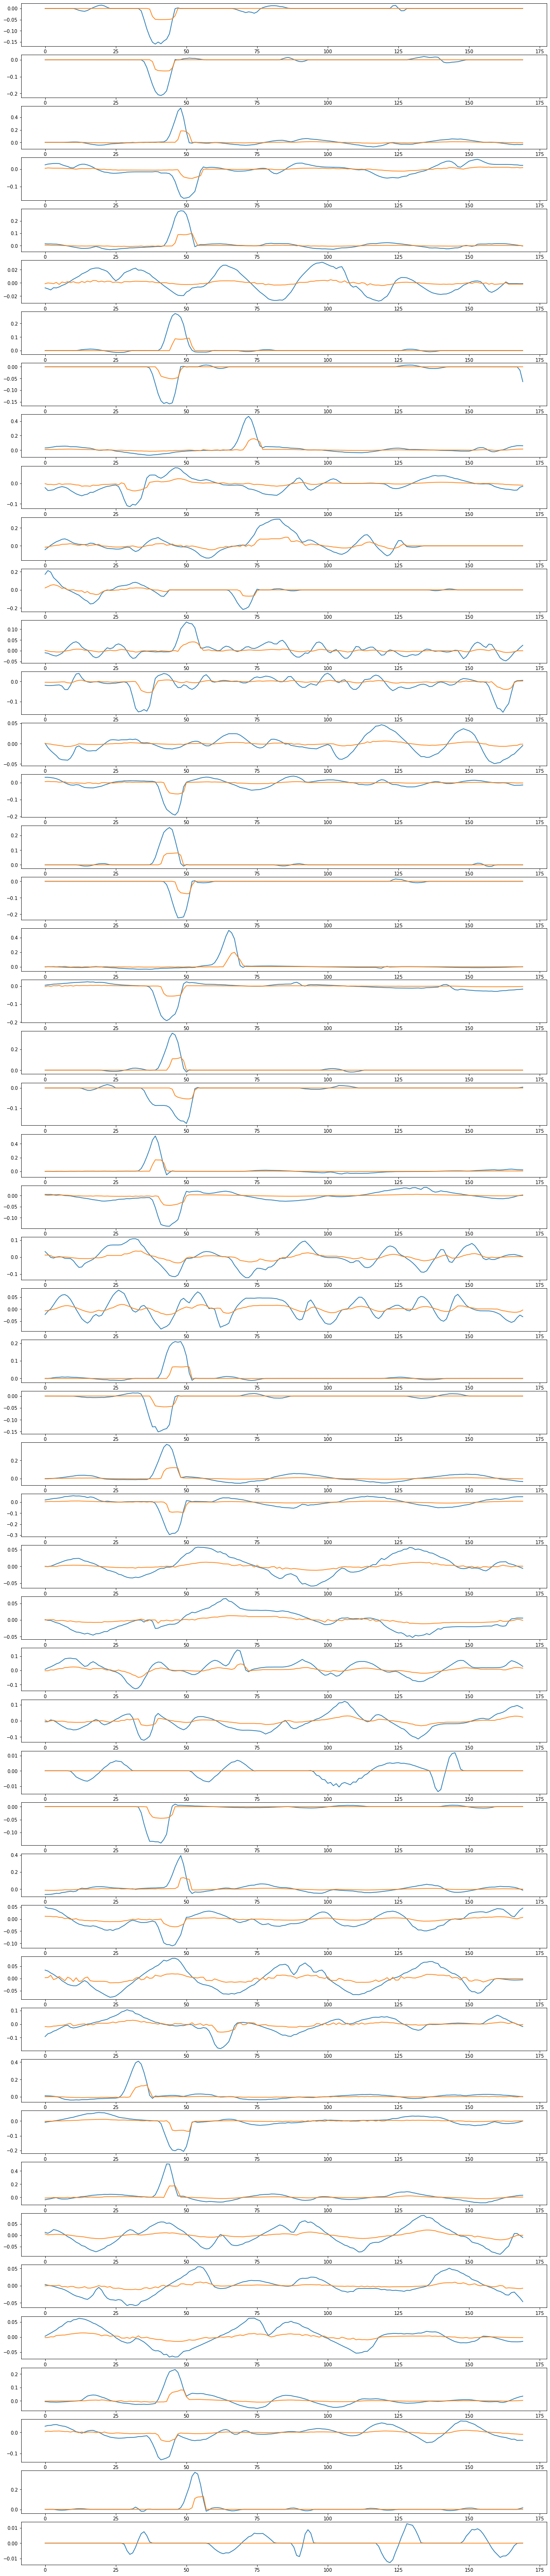

In [27]:
n_cols = 1
l = 50 # can't do all, otherwise crash
n_rows = math.ceil(l/n_cols)
fig, subplots = plt.subplots(n_rows,n_cols, figsize=(20,n_rows*2)) # figsize is w,h
subplots = subplots.flatten()

for i in range(l):
    ax = subplots[i]
    ax.plot(aux[i, :, 'tire_angle'])
    ax.plot(aux[i, :, 'curvature_at_ego'])    
    #ax.plot(aux[i, :, 'tire_angle_lagged'])
    

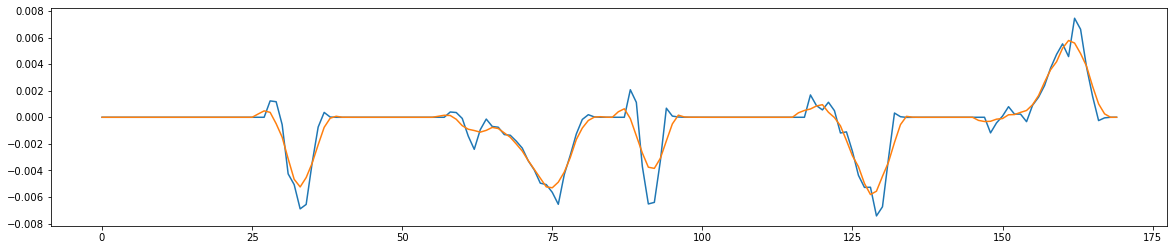

In [28]:
plt.figure(figsize=(20,4))
plt.plot(all_wp_angles[49, :200, 0])
plt.plot(moving_average(all_wp_angles[49, :200, 0], w=5))

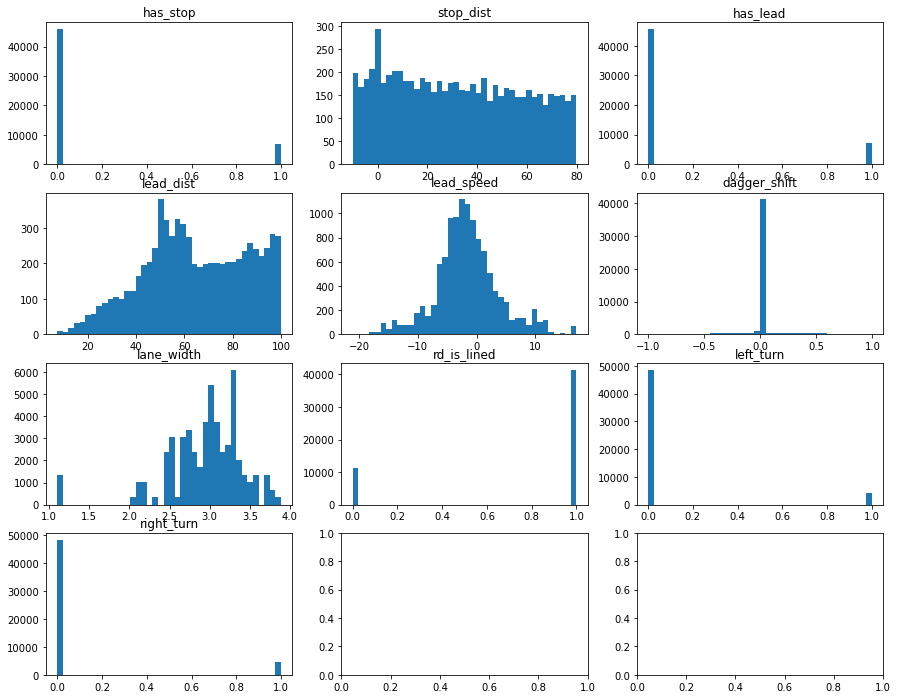

In [29]:
plot_aux(aux, AUX_TARGET_PROPS)

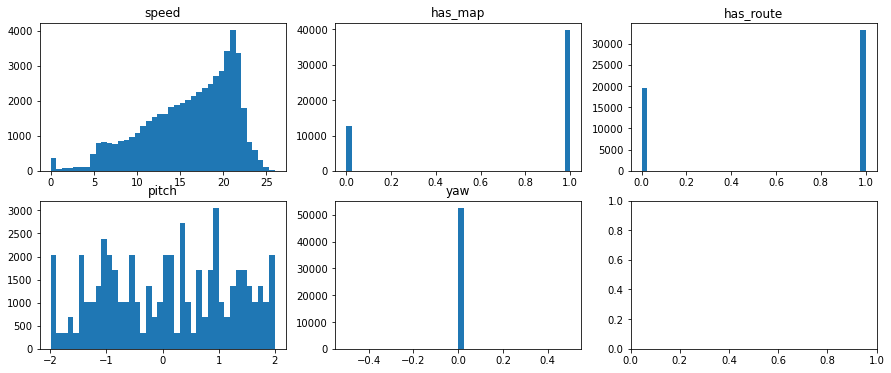

In [30]:
plot_aux(aux, AUX_MODEL_PROPS)

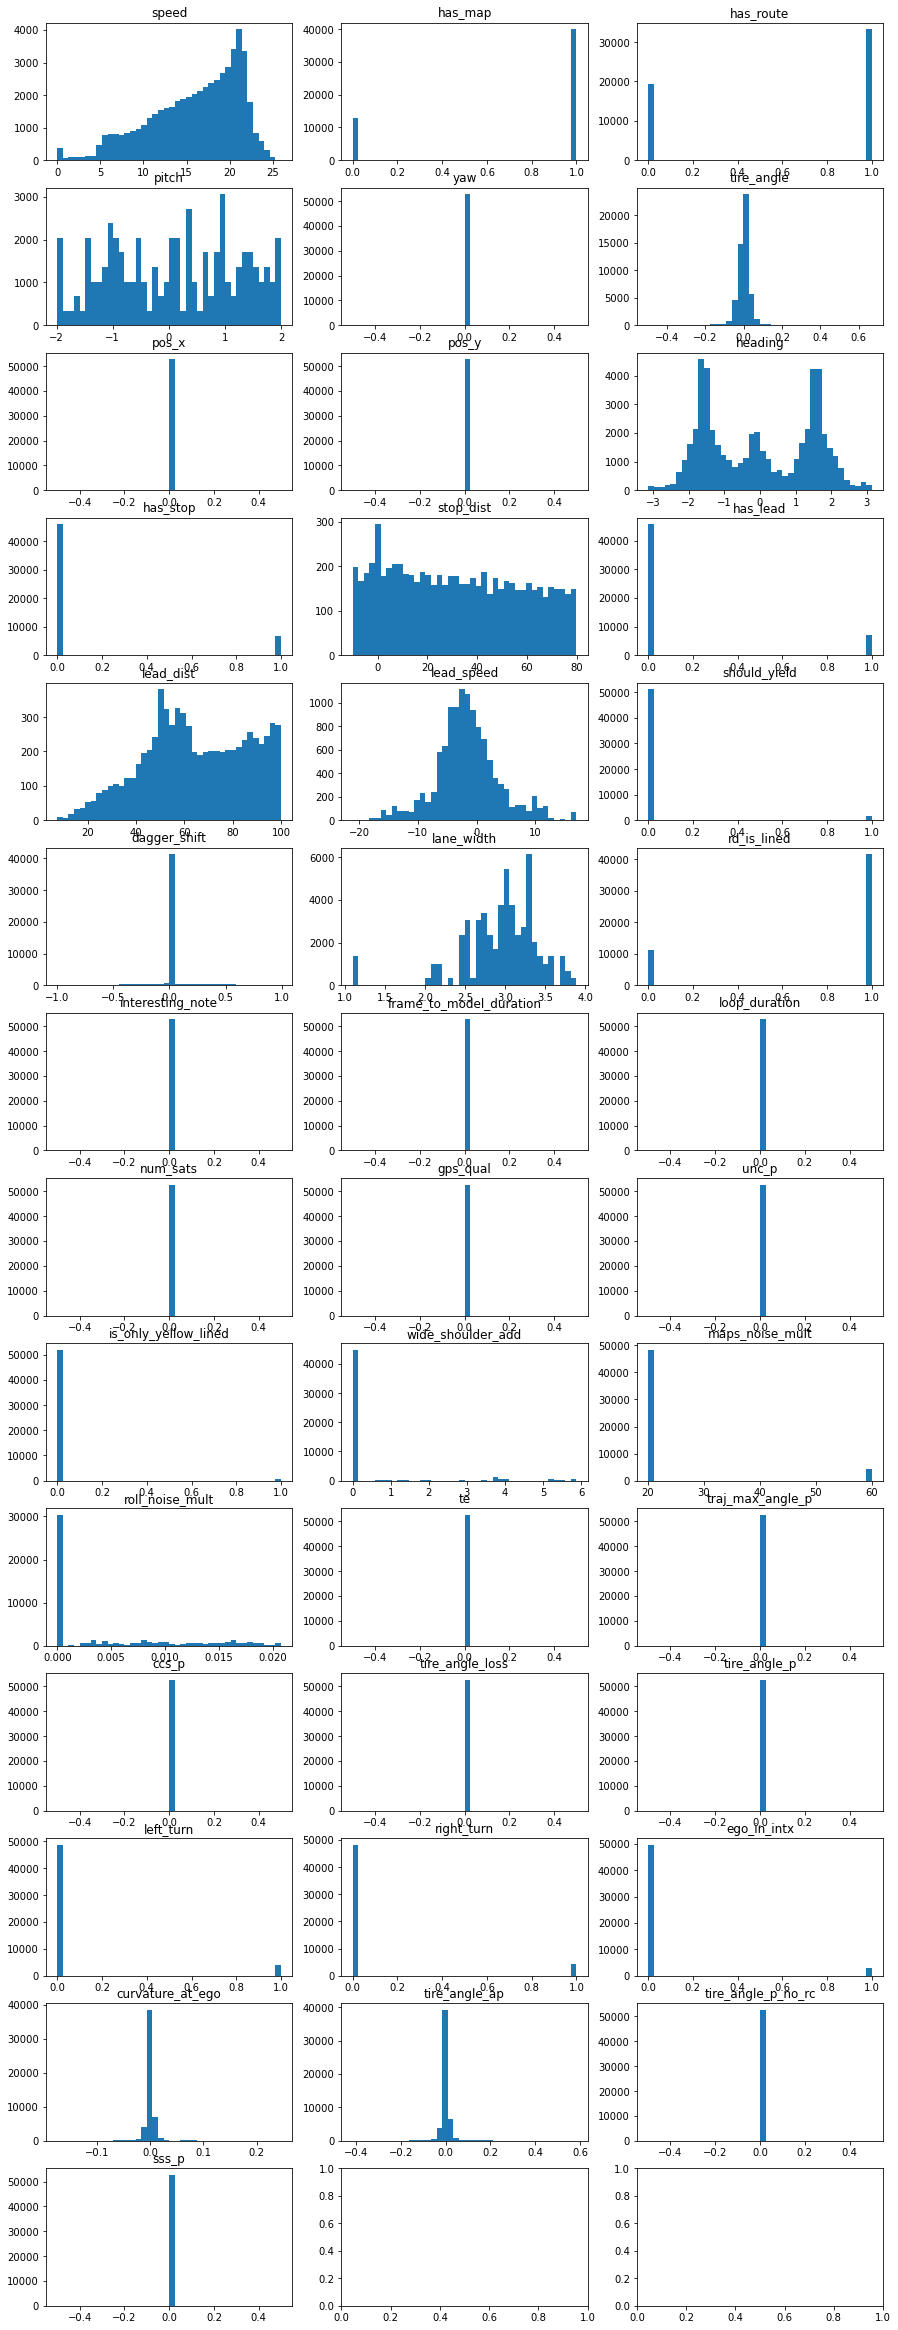

In [31]:
plot_aux(aux, AUX_PROPS)

In [32]:
aux[:,:,'has_stop'].mean()

NamedArray(0.12905124, dtype=float32)

In [33]:
np.quantile(abs(aux[:,:,"tire_angle"]), .99) #TODO this was .137, check again

0.2096100331842897

In [34]:
abs(aux[:,:,"tire_angle"]).max()

NamedArray(0.6548391, dtype=float32)

In [35]:
aux[:,:,"dagger_shift"].min()

NamedArray(-0.9964083, dtype=float32)

(array([52., 35., 19., 14., 10.,  5., 12., 11.,  5.,  7.]),
 NamedArray([0.01257083, 0.03629391, 0.060017  , 0.08374009, 0.10746317,
             0.13118626, 0.15490934, 0.17863244, 0.20235552, 0.22607861,
             0.2498017 ], dtype=float32),
 <BarContainer object of 10 artists>)

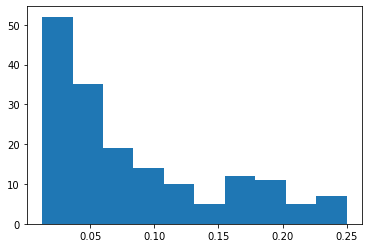

In [36]:
plt.hist(aux[:,:,"curvature_at_ego"].max(0))

In [37]:
m = aux[:,:,"curvature_at_ego"].max(0)
len(m[m<.3]) / len(m)

1.0